In [1]:
#%pylab inline
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
plt.style.use('ggplot') 
import datetime as dt

In [2]:
import yatsm
from yatsm.io import read_pixel_timeseries
from yatsm.utils import csvfile_to_dataframe, get_image_IDs
from yatsm.config_parser import convert_config, parse_config_file
from yatsm.config_parser import convert_config, parse_config_file
import yatsm._cyprep as cyprep

In [3]:
## SPECIFY CONFIG FILE
config_file = '/projectnb/landsat/users/valpasq/LCMS/stacks/p045r030/p045r030_config_LCMS.yaml'

# Read in and parse config file
cfg = parse_config_file(config_file)

/projectnb/landsat/users/valpasq/conda/envs/forest/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# Get files list
df = csvfile_to_dataframe(cfg['dataset']['input_file'], \
                          date_format=cfg['dataset']['date_format'])

In [9]:
# SPECIFY PIXEL ROW AND COLUMN
py = 4796 # row 
px = 4255 # column
name = 'Site 3' # pixel name (for plot titles)

# SPECIFY DATES for vertical lines on TS figures
#change_date = datetime.datetime.strptime('2010 050', '%Y %j')
change_date = [] # if none
#CCDC_date = datetime.datetime.strptime('2006 111', '%Y %j')
CCDC_date = [] # if none

# Get dates for image stack
df['image_ID'] = get_image_IDs(df['filename']) 
df['x'] = df['date'] 
dates = df['date'].values

# Read in time series as numpy array
Y = read_pixel_timeseries(df['filename'], px, py)

if (Y[0:6] == -9999).mean() > 0.3: # skip if TS is all nodata
    pass

else: # process time series

    # Mask based on physical constraints and Fmask 
    valid = cyprep.get_valid_mask( \
                Y, \
                cfg['dataset']['min_values'], \
                cfg['dataset']['max_values']).astype(bool)

    # Apply mask band
    idx_mask = cfg['dataset']['mask_band'] - 1
    valid *= np.in1d(Y.take(idx_mask, axis=0), \
                             cfg['dataset']['mask_values'], \
                             invert=True).astype(np.bool)

    # Mask time series using fmask result
    Y_fmask = np.delete(Y, idx_mask, axis=0)[:, valid]
    dates_fmask = dates[valid]

    # Apply multitemporal mask - original time series (no fmask)
    # Multi-temp only TS used for TCG range - preserves more winter obs
    # Step 1. mask where green > 3 stddev
    multitemp1 = np.where(Y[1] < (np.mean(Y_fmask[1])+np.std(Y_fmask[1])*3))
    dates_multi = dates[multitemp1[0]] 
    Y_multi = Y[:, multitemp1[0]]
    # Step 2. mask where swir < 3 std dev
    multitemp2 = np.where(Y_multi[4] > (np.mean(Y_fmask[4])-np.std(Y_fmask[4])*3))
    dates_multi = dates_multi[multitemp2[0]] 
    Y_multi = Y_multi[:, multitemp2[0]]
    Y_multi = Y_multi.astype(float)/10000

    # Apply multi-temporal mask - fmask time series
    # Fully masked TS used for TCB & TCW
    # Step 1. mask where green > 3 stddev
    multitemp1_fmask = np.where(Y_fmask[1] < (np.mean(Y_fmask[1])+np.std(Y_fmask[1])*3))
    dates_fmask = dates_fmask[multitemp1_fmask[0]] 
    Y_fmask = Y_fmask[:, multitemp1_fmask[0]]
    # Step 2. mask where swir < 3 std dev
    multitemp2_fmask = np.where(Y_fmask[4] > (np.mean(Y_fmask[4])-np.std(Y_fmask[4])*3))
    dates_fmask = dates_fmask[multitemp2_fmask[0]] 
    Y_fmask = Y_fmask[:, multitemp2_fmask[0]]
    Y_fmask = Y_fmask.astype(float)/10000

    # convert time from ordinal to dates
    dt_dates_multi = np.array([dt.datetime.fromordinal(d) for d in dates_multi])
    dt_dates_fmask = np.array([dt.datetime.fromordinal(d) for d in dates_fmask])

    # Create dataframes for analysis
    # Fmasked + multitemporal masked data (for TCB and TCW TS)
    # Step 1. reshape data
    shp_ = dt_dates_fmask.shape[0]
    dt_dates_fmask_csv = dt_dates_fmask.reshape(shp_, 1)
    Y_fmask_csv = np.transpose(Y_fmask)
    data_fmask = np.concatenate([dt_dates_fmask_csv, Y_fmask_csv], axis=1)
    col_names = ['date', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw']
    band_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw']
    # Step 2. create dataframe
    data_fmask_df = pd.DataFrame(data_fmask, columns=col_names)
    # convert reflectance to int
    data_fmask_df[band_names] = data_fmask_df[band_names].astype(float) 
    # Step 3. group by year to generate annual TS
    year_group_fmask = data_fmask_df.groupby(data_fmask_df.date.dt.year)
    # get years in time series 
    years_fmask = np.asarray(year_group_fmask.groups.keys()) 
    years_fmask = years_fmask.astype(int)

    # Multitemporal only masked data (for TCG TS)
    # Step 1. reshape data
    shp_ = dt_dates_multi.shape[0]
    dt_dates_multi_csv = dt_dates_multi.reshape(shp_, 1)
    Y_multi_csv = np.transpose(Y_multi)
    data_multi = np.concatenate([dt_dates_multi_csv, Y_multi_csv], axis=1)
    col_names = ['date', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw', 'fmask']
    # Step 2. create dataframe
    data_multi_df = pd.DataFrame(data_multi, columns=col_names)
    # convert reflectance to int
    data_multi_df[band_names] = data_multi_df[band_names].astype(float) # convert reflectance to int
    # Step 3. group by year to generate annual TS
    year_group_multi = data_multi_df.groupby(data_multi_df.date.dt.year) # annual time series
    # get years in time series 
    years_multi = np.asarray(year_group_multi.groups.keys()) # years in time series
    years_multi = years_multi.astype(int)

    # TC Brightness Change Detection - Flood
    # Calculate mean annual TCB
    TCB_mean = year_group_fmask['tcb'].mean()
    # Calculate year-to-year difference in mean TCB
    TCB_mean_diff = np.diff(TCB_mean)
    # Cumulative sum of annual difference in TCB
    TCB_mean_sum = np.cumsum(TCB_mean_diff)
    # percentile clip 
    TCB_iqr_H = year_group_fmask['tcb'].quantile([.90])
    TCB_iqr_L = year_group_fmask['tcb'].quantile([.10])
    TCB_iqr = np.asarray(TCB_iqr_H - TCB_iqr_L)

    # TC Greenness Change Detection - Vegetation
    TCG_mean = year_group_fmask['tcg'].mean()
    # Find annual min TCG
    TCG_min = year_group_fmask['tcg'].min()
    # Find annual max TCG
    TCG_max = year_group_fmask['tcg'].max()  
    # Calculate annual range TCG       
    TCG_amp = np.asarray(TCG_max - TCG_min)
    # Normalize to first year's value (assuming forest)
    #TCG_amp_adj = TCG_amp.astype(float) / TCG_amp[0].astype(float) 
    # percentile clip 
    TCG_iqr_H = year_group_fmask['tcg'].quantile([.90])
    TCG_iqr_L = year_group_fmask['tcg'].quantile([.10])
    TCG_iqr = np.asarray(TCG_iqr_H - TCG_iqr_L)
    
    # TC Wetness Change Detection - Flood
    # Calculate mean annual TCW
    TCW_mean = year_group_fmask['tcw'].mean()
    # Calculate year-to-year difference in mean TCB
    TCW_mean_diff = np.diff(TCW_mean)
    # Cumulative sum of annual difference in TCB
    TCW_mean_sum = np.cumsum(TCW_mean_diff)
    # percentile clip 
    TCW_iqr_H = year_group_fmask['tcw'].quantile([.90])
    TCW_iqr_L = year_group_fmask['tcw'].quantile([.10])
    TCW_iqr = np.asarray(TCW_iqr_H - TCG_iqr_L)  
    
print('Time series processing complete!')



Time series processing complete!


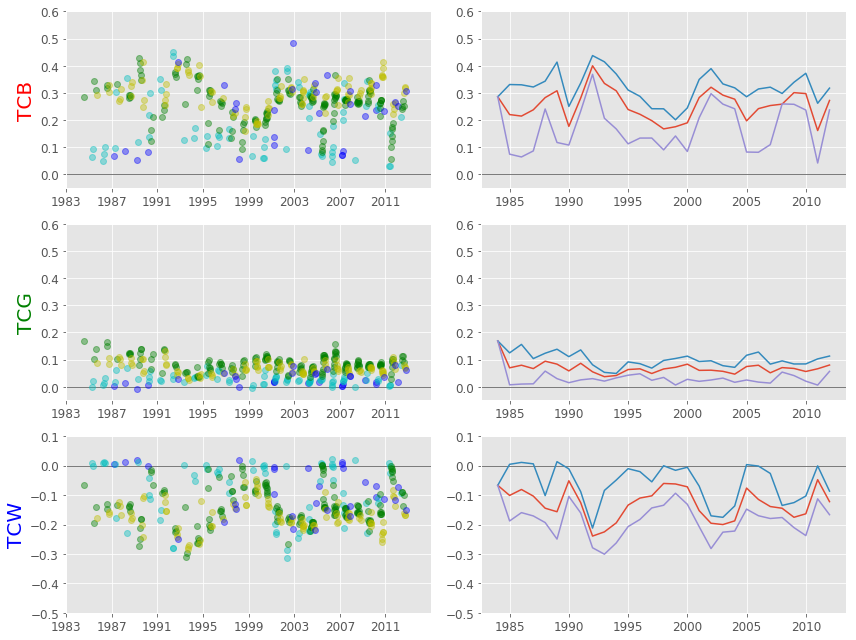

In [10]:
# Time series figure -- 
fig = plt.figure(figsize=(12,9),facecolor='w', edgecolor='k')
xmin = dt.datetime.strptime('1983 1', '%Y %j')
xmax = dt.datetime.strptime('2014 365', '%Y %j')

ax = fig.add_subplot(321)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line
for date in dt_dates_fmask:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'yo', alpha=0.4)  
#TCB_mean_arr = np.asarray(TCB_mean)
#for index, tcb in enumerate(TCB_mean):
#    date = dt.date(year_group_fmask.groups.keys()[index], 6, 1)
#    plt.plot(date, tcb, 'ko')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylabel('TCB', fontsize=20, color='r')
plt.ylim((-0.0500, 0.6000))
plt.xlim((xmin, xmax))
#plt_mean = mlines.Line2D([], [], linewidth=0, color='k', marker='o',
#                          markersize=5, label='mean')
#plt.legend(handles=[plt_mean], fontsize=16, loc='best')


ax = fig.add_subplot(322)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line
plt.plot(TCB_mean)
plt.plot(TCB_iqr_H.keys().levels[0], TCB_iqr_H[:].values)
plt.plot(TCB_iqr_L.keys().levels[0], TCB_iqr_L[:].values)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylim((-0.0500, 0.6000))

ax = fig.add_subplot(323)
#plt.xlim((date1, date2))
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line
for date in dt_dates_fmask:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_fmask[8, np.where(dt_dates_fmask==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_fmask[8, np.where(dt_dates_fmask==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_fmask[8, np.where(dt_dates_fmask==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_fmask[8, np.where(dt_dates_fmask==date)],'yo', alpha=0.4)
#TCG_max_arr = np.asarray(TCG_iqr_H)
#for index, tcg_max in enumerate(TCG_iqr_H):
#    date = dt.date(year_group_fmask.groups.keys()[index], 1, 1)
#    plt.plot(date, tcg_max, marker='v', color='k', markersize=9)
#TCG_min_arr = np.asarray(TCG_iqr_L)
#for index, tcg_min in enumerate(TCG_iqr_L):
#    date = dt.date(year_group_fmask.groups.keys()[index], 6, 1)
#    plt.plot(date, tcg_min, marker='^', color='k', markersize=9)
plt.ylabel('TCG', fontsize=20, color='g')
plt.ylim((-0.0500, 0.6000))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)  
plt.xlim((xmin, xmax))
#plt_max = mlines.Line2D([], [], linewidth=0, color='k', marker='v',
#                          markersize=7, label='max')
#plt_min = mlines.Line2D([], [], linewidth=0, color='k', marker='^',
#                          markersize=7, label='min')
#plt.legend(handles=[plt_max, plt_min], fontsize=16, loc='best')

ax = fig.add_subplot(324)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line
plt.plot(TCG_mean)
plt.plot(TCG_iqr_H.keys().levels[0], TCG_iqr_H[:].values)
plt.plot(TCG_iqr_L.keys().levels[0], TCG_iqr_L[:].values)
plt.ylim((-0.0500, 0.6000))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0) 

ax = fig.add_subplot(325)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  
for date in dt_dates_fmask:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_fmask[9, np.where(dt_dates_fmask==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_fmask[9, np.where(dt_dates_fmask==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_fmask[9, np.where(dt_dates_fmask==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_fmask[9, np.where(dt_dates_fmask==date)],'yo', alpha=0.4)
#TCW_mean_arr = np.asarray(TCW_mean)
#for index, tcw in enumerate(TCW_mean):
#    date = dt.date(year_group_fmask.groups.keys()[index], 6, 1)
#    plt.plot(date, tcw, 'ko')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylabel('TCW', fontsize=20, color='b')
plt.ylim((-0.5, 0.1000))
plt.xlim((xmin, xmax))

ax = fig.add_subplot(326)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line
plt.plot(TCW_mean)
plt.plot(TCW_iqr_H.keys().levels[0], TCW_iqr_H[:].values)
plt.plot(TCW_iqr_L.keys().levels[0], TCW_iqr_L[:].values)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylim((-0.5, 0.1000))

fig.tight_layout()
plt.savefig('./{y}_{x}_TCpanel_{name}.png'.format(x=px, y=py, name=name))
plt.show()